In [1]:
import pandas as pd
import time
import numpy as np
import os
from collections import defaultdict
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data = pd.read_csv("Induced Musical Emotion.csv")
data

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,0,26,1,Russian
8403,400,pop,0,0,0,1,0,0,1,0,1,3,0,1,29,0,Russian
8404,400,pop,0,0,0,0,0,0,0,1,0,4,0,1,34,1,Polish
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,0,39,1,French


In [ ]:
data[data[' genre'] == 'classical']

In [61]:
data = data[:8405]
df = data.drop(['track id', ' genre', ' mood', ' liked', ' disliked', ' age', ' gender', ' mother tongue'], axis=1)
df

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness
0,0,1,0,0,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0
4,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8400,0,0,0,0,0,0,0,0,1
8401,0,0,0,0,0,0,0,1,0
8402,1,1,0,0,0,0,1,0,0
8403,0,0,0,1,0,0,1,0,1


In [42]:
np.mean(data[' liked'])

0.3915526472337894

In [43]:
np.var(data[' liked'])

0.2382391716780011

In [62]:
y = data[' liked'].to_numpy()
X = df.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 1681
K = int(total_samples/T)

p = 1.5
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

In [63]:
get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

In [64]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:148: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


array([0.        , 0.5       , 0.33333333, ..., 0.49374628, 0.49404762,
       0.49375372])

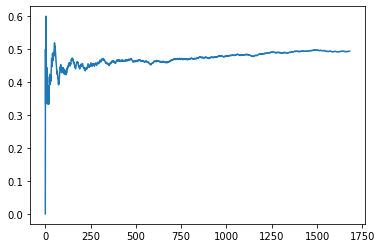

In [66]:
plt.plot(error_list)
error_list